In [418]:
#load required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

The real estate transactions data is all in the nyc.gov website. The tricky part is the naming convention for the URL is not consistent. There are three naming conventions and so I ended up with a number of try/except loops to make sure I captured them all.

In [45]:
#only use this section if you need to download from scratch

#code to download all manhattan excel sheets
urlstart = "https://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/"
urlstart2 = "https://www1.nyc.gov/assets/finance/downloads/sales_manhattan_"
urlstart3 = "https://www1.nyc.gov/assets/finance/downloads/excel/rolling_sales/sales_"
urlend = "_manhattan.xls"
urlendx = "_manhattan.xlsx"
dflist = []


for i in range (2003,2021):
    try:
        fullurl = (urlstart + str(i) + "/" + str(i) + urlend)
        dfname = "df" + str(i)
        dfname = pd.read_excel(fullurl)
        dfname['Year'] = i
        print(str(i) + " data loaded")
        dflist.append(dfname)
        
    except:
        try:
            print("try xlsx for " + str(i))
            fullurl = (urlstart + str(i) + "/" + str(i) + urlendx)
            dfname = "df" + str(i)
            dfname = pd.read_excel(fullurl)
            dfname['Year'] = i
            print(str(i) + " data loaded")
            dflist.append(dfname)
        except:
            try:
                print("try two digit load for " + str(i))
                fullurl = (urlstart2 + str(i)[-2:] + ".xls")
                dfname = "df" + str(i)
                dfname = pd.read_excel(fullurl)
                print(str(i) + " data loaded")
                dfname['Year'] = i
                dflist.append(dfname)
            except:
                try:
                    print("Try the last attempt for " + str(i))
                    fullurl = (urlstart3 + str(i) + urlend)
                    dfname = "df" + str(i)
                    dfname = pd.read_excel(fullurl)
                    print(str(i) + " data loaded")
                    dfname['Year'] = i
                    dflist.append(dfname)
                except:
                    try:
                        dfname = pd.read_excel("https://www1.nyc.gov/assets/finance/downloads/pdf/09pdf/rolling_sales/sales_2008_manhattan.xls")
                        dfname['Year'] = i
                        dflist.append(dfname)
                        print(f'Year {i} loaded')
                    except:
                        try:
                            dfname = pd.read_excel("https://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2009_manhattan.xls")
                            dfname['Year'] = i
                            dflist.append(dfname)
                            print(f'Year {i} loaded')
                        except:
                            print(f'Year {i} could not load.')

try xlsx for 2003
try two digit load for 2003
2003 data loaded
try xlsx for 2004
try two digit load for 2004
2004 data loaded
try xlsx for 2005
try two digit load for 2005
2005 data loaded
try xlsx for 2006
try two digit load for 2006
2006 data loaded
try xlsx for 2007
try two digit load for 2007
Try the last attempt for 2007
2007 data loaded
try xlsx for 2008
try two digit load for 2008
Try the last attempt for 2008
Year 2008 loaded
try xlsx for 2009
try two digit load for 2009
Try the last attempt for 2009
Year 2009 loaded
2010 data loaded
2011 data loaded
2012 data loaded
2013 data loaded
2014 data loaded
2015 data loaded
2016 data loaded
2017 data loaded
try xlsx for 2018
2018 data loaded
try xlsx for 2019
2019 data loaded
try xlsx for 2020
2020 data loaded


Clean up the data. Drop unnecessary columns, change datatypes, streamline strings.

In [47]:
df = pd.concat(dflist)
df.to_csv("manhattan_sales.xls")
df = pd.read_csv("manhattan_sales.xls")

#set proper column headers and clean up column names
df.columns = df.iloc[2]
mycolumns = list(df.columns)
newlist = []

for col in mycolumns:
    col = str(col).replace("\n","")
    col = str(col).replace("''","")
    col = col.strip()
    newlist.append(col)
print(newlist)
df.columns = newlist
df.rename(columns={"2003": "year sold"},inplace=True)

df = df.rename(columns=str.lower)

#count null values and remove columns with too mnay null values
countnulls = df.isnull().sum(axis=0).sort_values()
lowcountnulls = countnulls < 1e5
print(lowcountnulls)
df.drop(['nan',"apartment number","borough","2","ease-ment"], axis = 1,inplace=True)
print(df.columns)

#convert datatype to numeric
numeric_cols = ["zip code","residential units","commercial units","total units",
                "land square feet","gross square feet","year built","sale price","year sold"]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce', axis=1)
print(df.dtypes)
#save clean xls to speed up process next time 
df.to_csv("manhattan_sales_clean.xls")

/Users/macproajb/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning:

Columns (1,5,6,7,11,12,13,14,15,16,17,18,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38) have mixed types.Specify dtype option on import or set low_memory=False.



['2', 'BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT', 'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT', 'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE', 'SALE PRICE', 'SALE DATE', '2003', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
2                                  True
year sold                          True
sale date                          True
sale price                         True
tax class at time of sale          True
zip code                           True
address                            True
building class at time of sale     True
lot                                True
neighborhood                       True
block                              True
building class category            True
building class

We end up with ~410k entries going back to 2003.

In [48]:
#start from here to make it speedier process
df = pd.read_csv("manhattan_sales_clean.xls")
#inspect random data samples to get a sense of data
df.sample(n=20, random_state=1)
df.shape

(410007, 20)

We inspect the data for unique categories in each column to get a sense of how granular the data gets. We'll have to categorize the data later to make relevant observations on large enough groups.

In [49]:
#check out unique categories in each column
for cols in df:
    print(f'This category is {cols}')
    print(df[cols].unique())

This category is Unnamed: 0
[     0      1      2 ... 410004 410005 410006]
This category is neighborhood
[nan 'NEIGHBORHOOD' 'ALPHABET CITY            '
 'CHELSEA                  ' 'CHINATOWN                '
 'CIVIC CENTER             ' 'CLINTON                  '
 'EAST VILLAGE             ' 'FASHION                  '
 'FINANCIAL                ' 'FLATIRON                 '
 'GRAMERCY                 ' 'GREENWICH VILLAGE-CENTRAL'
 'GREENWICH VILLAGE-WEST   ' 'HARLEM-CENTRAL           '
 'HARLEM-EAST              ' 'HARLEM-UPPER             '
 'HARLEM-WEST              ' 'INWOOD                   '
 'JAVITS CENTER            ' 'KIPS BAY                 '
 'LITTLE ITALY             ' 'LOWER EAST SIDE          '
 'MANHATTAN VALLEY         ' 'MIDTOWN CBD              '
 'MIDTOWN EAST             ' 'MIDTOWN WEST             '
 'MORNINGSIDE HEIGHTS      ' 'MURRAY HILL              '
 'SOHO                     ' 'SOUTHBRIDGE              '
 'TRIBECA                  ' 'UPPER BAY         

We start filtering out outliers, nonrelevant data, and improving descriptors used.

Shape before filtering out values is (410007, 20)
Shape after filtering out values is (326457, 20)
Shape before filtering out values is (326457, 20)
Float64Index([10023.0, 10021.0, 10016.0, 10011.0, 10022.0, 10019.0, 10025.0,
              10128.0, 10024.0, 10003.0, 10028.0, 10014.0, 10065.0, 10017.0,
              10013.0, 10010.0, 10036.0, 10075.0, 10002.0, 10012.0, 10026.0,
              10027.0, 10001.0, 10038.0, 10280.0, 10069.0, 10005.0, 10009.0,
              10007.0, 10033.0, 10031.0, 10029.0, 10032.0, 10040.0, 10035.0,
              10034.0, 10030.0, 10006.0, 10004.0, 10039.0, 10044.0, 10018.0,
              10037.0],
             dtype='float64')
Shape after filtering out values is (325646, 20)
95% of residential homes are below $4,750,000
Shape before filtering out values is (325646, 20)
Shape after filtering out values is (309281, 20)


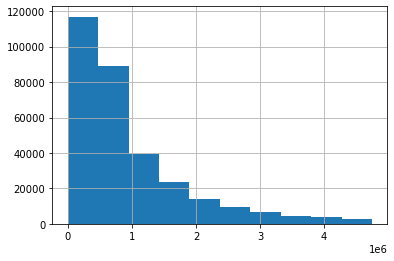

In [51]:
#filter out for only residential values
print(f'Shape before filtering out values is {df.shape}')
df["tax class at time of sale"].value_counts()
residential_values= [2,'2']
filtered_df = df[df["tax class at time of sale"].isin(residential_values)]
print(f'Shape after filtering out values is {filtered_df.shape}')

#filter out zip codes with less than 500 transactions
print(f'Shape before filtering out values is {filtered_df.shape}')
filter1 = filtered_df["zip code"].value_counts() > 500
filter2 = filter1[filter1].index
print(filter2)
filtered_df = filtered_df[filtered_df["zip code"].isin(filter2)]
print(f'Shape after filtering out values is {filtered_df.shape}')
filtered_df["zip code"].value_counts()

#filter out sales prices over $10mn and change unit to millions
quantile_cut = .95
highend = filtered_df["sale price"].quantile(quantile_cut)
print(f'{quantile_cut * 100:.0f}% of residential homes are below ${highend:,.0f}')
print(f'Shape before filtering out values is {filtered_df.shape}')
filtered_df = filtered_df[filtered_df["sale price"] < highend] #filter out top 5% of homes
#there are almost 55k transactions listed as $0 sale price which the glossary states is
#transfer of ownership without cash payment such as parents transfering to kids. We filter those out as well
filtred_df = filtered_df[filtered_df["sale price"] < 1]
print(f'Shape after filtering out values is {filtered_df.shape}')
filtered_df["sale price"].hist(bins=10)

#filter by decade by rounding down to nearest ten
filtered_df["decade built"] = round(filtered_df["year built"],-1)
#filtered_df["decade built"].value_counts().sort_index().plot(kind="bar")

#filter for broad categories where R condos, C is walkups, D is coops, S is majority stores
filtered_df["building class at time of sale"].value_counts()
filtered_df['broad building category'] = filtered_df["building class at time of sale"].astype(str).str[0]
building_cat_dict = {"R":"condos","D":"co-ops","C":"walk-ups","S":"stores"}
filtered_df["broad building category"] = filtered_df["broad building category"].map(building_cat_dict)
filtered_df["broad building category"].value_counts()

#clean up neighborhood names
df["neighborhood"] = df["neighborhood"].str.lower()
df["neighborhood"] = df["neighborhood"].str.strip()

#clean up neighborhood definitions. UWS is listed as three separate blocks of streets for example.
broader_neighborhoods = {'1021': 'other',
 '1026': 'other',
 'alphabet city': 'alphabet city',
 'chelsea': 'chelsea',
 'chinatown': 'chinatown',
 'civic center': 'lower manhattan',
 'clinton': 'hells kitchen',
 'east village': 'east village',
 'fashion': 'chelsea',
 'financial': 'financial',
 'flatiron': 'flatiron/gramercy',
 'gramercy': 'flatiron/gramercy',
 'greenwich village-central': 'greenwich',
 'greenwich village-west': 'greenwich',
 'harlem-central': 'harlem',
 'harlem-east': 'harlem',
 'harlem-upper': 'harlem',
 'harlem-west': 'harlem',
 'inwood': 'inwood',
 'javits center': 'javits center',
 'kips bay': 'murray hill',
 'little italy': 'soho',
 'lower east side': 'LES',
 'manhattan valley': 'UWS',
 'manhattan-unknown': 'other',
 'midtown cbd': 'midtown',
 'midtown east': 'midtown',
 'midtown west': 'midtown',
 'morningside heights': 'morningside heights',
 'murray hill': 'murray hill',
 'roosevelt island':  'roosevelt island',
 'soho': 'soho',
 'southbridge': 'lower manhattan',
 'tribeca': 'tribeca',
 'upper east side (59-79)': 'UES',
 'upper east side (79-96)': 'UES',
 'upper east side (96-110)': 'UES',
 'upper west side (59-79)': 'UWS',
 'upper west side (79-96)': 'UWS',
 'upper west side (96-116)': 'UWS',
 'washington heights lower': 'washington heights',
 'washington heights upper': 'washington heights'}

#rename neighborhoods and see new list
filtered_df["broader_neighborhoods"] = filtered_df["neighborhood"].map(broader_neighborhoods)
filtered_df["broader_neighborhoods"].value_counts()

#create unique property id
filtered_df["property id"] = filtered_df["block"].astype(str) + "---" + filtered_df["lot"].astype(str)

We're going to be spending a bit of time perusing the data and so it's worth it to create functions to do this more quickly.

In [53]:
def scan_data(column, datapoint):
    #quick way to scan through filtered data
    filtered_df_year = filtered_df[filtered_df[column] == datapoint]
    return(filtered_df_year.sample(n=10,random_state=5))

def quick_pivot(col1, col2, col3):
    #quick pivot function
    #col1 ends as index so usually time, col2 is category and columns, col3 is the value so usually price
    dfg = filtered_df.groupby([col1,col2])[col3].mean().reset_index()
    dfg = dfg.pivot(index=col1,columns=col2,values=col3)
    return(dfg)

#for example. To glance at data of building built into 2010 you can do
scan_data("year built",2010)

,Unnamed: 0,neighborhood,building class category,tax class at present,block,lot,building class at present,address,zip code,residential units,...,year built,tax class at time of sale,building class at time of sale,sale price,sale date,year sold,decade built,broad building category,broader_neighborhoods,property id
324014,324014,civic center,13 CONDOS - ELEVATOR APARTMENTS,2,149,1168,R4,57 READE STREET,10007.0,1.0,...,2010.0,2,R4,2500000.0,2016-03-03 00:00:00,2016.0,2010.0,condos,lower manhattan,149---1168
193519,193519,tribeca,13 CONDOS - ELEVATOR APARTMENTS,2,218,1312,R4,415 WASHINGTON STREET,10013.0,1.0,...,2010.0,2,R4,1781937.0,2010-07-01 00:00:00,2010.0,2010.0,condos,tribeca,218---1312
252862,252862,harlem-east,13 CONDOS - ELEVATOR APARTMENTS,2,1631,1037,R4,1635 LEXINGTON AVENUE,10029.0,1.0,...,2010.0,2,R4,549855.0,2013-09-12 00:00:00,2013.0,2010.0,condos,harlem,1631---1037
349536,349536,harlem-east,13 CONDOS - ELEVATOR APARTMENTS,2,1631,1035,R4,1635 LEXINGTON AVENUE,10029.0,1.0,...,2010.0,2,R4,801362.0,2017-02-10 00:00:00,2017.0,2010.0,condos,harlem,1631---1035
253931,253931,little italy,13 CONDOS - ELEVATOR APARTMENTS,2,507,1118,R4,250 BOWERY,10012.0,1.0,...,2010.0,2,R4,1725933.0,2013-07-15 00:00:00,2013.0,2010.0,condos,soho,507---1118
185006,185006,harlem-central,08 RENTALS - ELEVATOR APARTMENTS,2,1756,23,D3,2083 MADISON AVENUE,10037.0,82.0,...,2010.0,2,D3,0.0,2010-06-15 00:00:00,2010.0,2010.0,co-ops,harlem,1756---23
386366,386366,lower east side,13 CONDOS - ELEVATOR APARTMENTS,2,276,1224,R4,"31 MONROE STREET, 11A",10002.0,1.0,...,2010.0,2,R4,650000.0,2019-10-30 00:00:00,2019.0,2010.0,condos,LES,276---1224
404057,404057,murray hill,17 CONDO COOPS,2C,885,1304,R9,"132 EAST 30TH STREET, 6A",10016.0,NaN,...,2010.0,2,R9,0.0,2020-01-01 00:00:00,2020.0,2010.0,condos,murray hill,885---1304
364273,364273,fashion,13 CONDOS - ELEVATOR APARTMENTS,2,838,1099,R4,400 5 AVENUE,10018.0,1.0,...,2010.0,2,R4,0.0,2018-03-30 00:00:00,2018.0,2010.0,condos,chelsea,838---1099
226906,226906,harlem-east,17 CONDOPS,2,1645,1102,R9,"1879 LEXINGTON AVENUE, 4E",10035.0,0.0,...,2010.0,2,R9,621093.0,2012-05-31 00:00:00,2012.0,2010.0,condos,harlem,1645---1102


The end goal will be to produce sets of grouped charts based on a specific feature. To simplify the plotting process I convert each feature into its own custom dataframe laid out in a very specific way.

In [431]:
#here i take features and create dataframes for easy plotting over time and on sale price
features_list = ['block','zip code','broader_neighborhoods', 'broad building category', 'decade built','neighborhood','building class category']
pivoted_dfs_list = []

for feature in features_list:
    dfname = quick_pivot("year sold",feature,"sale price")
    pivoted_dfs_list.append(dfname)

i = 0 
for dfs in pivoted_dfs_list:
    print(f'{i}. {dfs.columns.name}')
    i += 1

pivoted_dfs_list[2]   

0. block
1. zip code
2. broader_neighborhoods
3. broad building category
4. decade built
5. neighborhood
6. building class category


broader_neighborhoods,LES,UES,UWS,alphabet city,chelsea,chinatown,east village,financial,flatiron/gramercy,greenwich,...,javits center,lower manhattan,midtown,morningside heights,murray hill,other,roosevelt island,soho,tribeca,washington heights
year sold,,,,,,,,,,,,,,,,,,,,,
2003.0,3.483998e+05,5.988886e+05,6.354109e+05,310788.174825,6.118237e+05,3.197649e+05,5.402068e+05,3.173233e+05,4.915885e+05,5.794964e+05,...,2.084325e+05,7.057482e+05,5.808940e+05,144749.500000,395470.137674,NaN,NaN,8.429562e+05,8.359652e+05,542082.190678
2004.0,4.722896e+05,8.312633e+05,6.817896e+05,447769.463415,7.518985e+05,7.100864e+05,5.080513e+05,5.632800e+05,6.261430e+05,8.329231e+05,...,3.574171e+05,1.170341e+06,6.889030e+05,238221.125000,501643.616791,NaN,NaN,1.219404e+06,1.035484e+06,492764.705769
2005.0,5.784955e+05,8.974426e+05,8.682434e+05,679234.089744,9.060505e+05,8.694001e+05,6.383266e+05,5.097493e+05,7.804172e+05,8.165732e+05,...,3.412284e+05,1.302838e+06,8.306271e+05,345802.033708,648008.849434,375000.000000,NaN,1.425594e+06,1.067813e+06,673313.256410
2006.0,6.842039e+05,9.342703e+05,9.154434e+05,597643.923077,8.830748e+05,8.421933e+05,7.697743e+05,8.024970e+05,9.172521e+05,7.367035e+05,...,4.953473e+05,1.052545e+06,8.215158e+05,745685.154639,681975.518939,104718.947368,NaN,1.384858e+06,1.231455e+06,404309.292593
2007.0,7.308621e+05,1.009624e+06,9.796017e+05,774057.605263,1.017851e+06,9.349508e+05,6.918978e+05,6.970964e+05,1.031423e+06,9.730701e+05,...,3.731609e+05,1.094751e+06,9.084234e+05,403391.322917,801462.742455,0.000000,NaN,1.664262e+06,1.259565e+06,593291.656489
2008.0,5.641277e+05,8.602314e+05,1.017593e+06,762554.547170,1.200939e+06,6.342419e+05,7.978234e+05,8.857694e+05,1.074292e+06,1.000964e+06,...,2.313753e+05,1.073631e+06,9.950693e+05,423735.806452,885711.237773,NaN,NaN,1.320997e+06,1.651343e+06,541114.230594
2009.0,5.641277e+05,8.602314e+05,1.017593e+06,762554.547170,1.200939e+06,6.342419e+05,7.978234e+05,8.857694e+05,1.074292e+06,1.000964e+06,...,2.313753e+05,1.073631e+06,9.950693e+05,423735.806452,885711.237773,NaN,NaN,1.320997e+06,1.651343e+06,541114.230594
2010.0,6.373504e+05,1.071526e+06,9.359006e+05,827378.974359,1.140640e+06,7.678552e+05,9.612174e+05,4.949612e+05,1.169615e+06,1.121022e+06,...,8.198848e+05,1.160529e+06,9.296996e+05,447583.818182,749854.942470,0.000000,NaN,1.567876e+06,1.549086e+06,468058.253012
2011.0,6.036240e+05,1.015857e+06,9.706805e+05,852328.495238,1.075969e+06,6.238489e+05,8.377263e+05,7.645836e+05,9.438359e+05,9.962747e+05,...,4.116285e+05,1.283153e+06,7.502402e+05,495539.734694,662420.900114,0.000000,NaN,1.309213e+06,1.376168e+06,460467.430380


Once we have a custom dataframe, the only tricky part is making sure that all charts display in a specific order
across rows and columns. A for loop with a counter takes care of that.

In [437]:
x = 3
#load chart from dataframe list above and prepare to plot
df_charts = pivoted_dfs_list[x]
print(df_charts.columns)
# if x == 2:
#     df_charts.drop(columns=["other","roosevelt island","inwood"],inplace=True) #this line is only for neighborhoods
    
df_charts = df_charts.sort_values(df_charts.last_valid_index(), axis=1,ascending=False)
fig = make_subplots(rows=5, cols=5, start_cell="top-left",subplot_titles=(df_charts.columns),shared_yaxes=True)
row_i = 1
col_i = 1
for cols in df_charts:
    fig.add_trace(go.Scatter(x=df_charts.index, y=df_charts[cols]),
                  row=row_i, col=col_i)
    if col_i < 5:
        col_i += 1
    else:
        col_i = 1
        row_i += 1
        
fig.update_annotations(font_size=12)
fig.update_yaxes(range=(0,2000000))
fig.update_layout(height=800, width=800, title_text=f'Average price per sale per neighborhood',showlegend=False)
# fig.show()

Index(['co-ops', 'condos', 'stores', 'walk-ups'], dtype='object', name='broad building category')


The dataset is quite rich in details. Some other questions worth considering:
1. Why is javits picking up in price so much?
2. Does condo/walkup mix matter for neighborhood pricing?
3. What is the priciest zip code over time?
4. What neighborhood has the most non-cash transactions?
5. Is there a prewar premium in NY?

1. Why is javits picking up in price so much?

In [75]:
#The jump in Javitz neighborhood happens recently. One theory is that the new development, Hudson Yards,
#may be changing the mix toward more luxury sales.

#One quick way to check this is to do a groupby to look at units sold each year based on when the building
#was constructed
df_javits = filtered_df[filtered_df["broader_neighborhoods"] == "javits center"].copy()
df_javits["short_address"] = df_javits["address"].astype(str).str[0:20]
pd.set_option('display.max_rows', 1000)
df_javits.groupby(["year sold", "year built"]).size()

#In 2019 and 2020, the bulk of sales come from building constructed in 2015. This vintage is not present in prior years.
#Unit sales volumes pick up quite significantly in 2019.

df_javits["year sold"].value_counts().sort_index()

#A few buildings account for the bulk of sales
df_javits = df_javits[df_javits["year sold"] == 2019]
df_javits.sample(n=10,random_state=5)

#And if you sort by sales price, the priciest sales all occur at the same place 553 West 30th. Some basic googling
#shows this is a Hudson Yards building with pricy units.
df_javits = df_javits.sort_values(by="sale price",ascending=False)
df_javits.head(20)

year sold  year built
2003.0     0.0            3
           1900.0         6
           1910.0         2
           1930.0        18
           1960.0         5
           1963.0        32
           2008.0         1
2004.0     0.0            4
           1900.0         3
           1920.0         1
           1930.0        19
           1960.0         7
           1963.0        13
           2008.0         1
2005.0     0.0            5
           1900.0         5
           1910.0         4
           1920.0         2
           1930.0        30
           1960.0         2
           1963.0        25
2006.0     0.0            1
           1900.0         1
           1920.0         1
           1930.0        20
           1960.0         1
           1963.0         9
2007.0     0.0            1
           1900.0         3
           1905.0         1
           1910.0         1
           1930.0        18
           1960.0         7
           1963.0        18
2008.0     0.0           2

2. Does condo/walkup mix matter for neighborhood pricing?

In [143]:
#We know from prior analysis that of the three main building types, condos have the highest average price, followed
#by coops, and then walkups. One theory as to why neighbors that are close to each other geographically might have
#vastly different average pricing is building type mix.

#We can construct a dataframe measuring this by using a groupby and pivot.
df_buildingmix  = filtered_df.groupby(["broader_neighborhoods","broad building category","year sold"])["sale price"].count()
df_buildingmix = df_buildingmix.reset_index()
df_buildingmix = df_buildingmix.pivot(index=["broader_neighborhoods","year sold"],columns="broad building category",values="sale price")

#We convert sales counts to #s by dividing type sold by total units sold
df_buildingmix_series = df_buildingmix.sum(axis=1)
df_totals = df_buildingmix_series.values
df_buildingmix = df_buildingmix.div(df_totals,axis=0)
df_buildingmix.reset_index(inplace=True)

#We can construct a datframe that looks at the share of condos sold per year per neighborhood.
df_condos = df_buildingmix.pivot(index="year sold",columns="broader_neighborhoods",values="condos")
df_condos = df_condos.sort_values(df_condos.last_valid_index(), axis=1,ascending=False)
df_condos.drop(columns=["other","roosevelt island","inwood"],inplace=True)
#print(df_condos)

#We'll do the same for walkups
df_walkups = df_buildingmix.pivot(index="year sold",columns="broader_neighborhoods",values="walk-ups")
df_walkups = df_walkups.sort_values(df_walkups.last_valid_index(), axis=1,ascending=False)
#print(df_walkups)


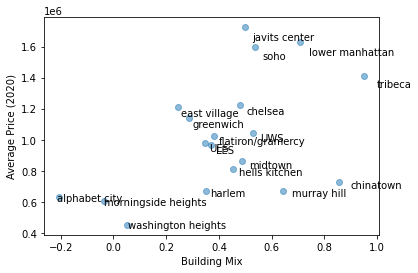

In [396]:
#Next we try to create a building mix index by taking share of condos sold and subtracting share of walkups sold.
#In theory, the more condos and the fewest walkups should lead to highest prices

df_buildingmix["mix index"] =df_buildingmix["condos"] - df_buildingmix["walk-ups"]
df_buildingmix2020 = df_buildingmix[df_buildingmix["year sold"] == 2020].sort_values(by="mix index")
df_buildingmix2020.set_index(["broader_neighborhoods"],inplace=True)
df_buildingmix2020.drop(["roosevelt island","inwood"],inplace=True)

x = df_buildingmix2020[["mix index"]].squeeze().sort_index()
y = pivoted_dfs_list[2].loc[2020].sort_index()

plt.scatter(x, y, alpha=0.5)
plt.xlabel("Building Mix")
plt.ylabel("Average Price (2020)")
annotations = list(df_buildingmix2020.sort_index().index)

for i, label in enumerate(annotations):
    plt.annotate(label, (x[i] * 1.05, y[i] * .95))  
plt.show()

#We do find some relationship between building mix and price. There are a few outliers worth exploring such as
#Chinatown and Murray Hill

3. What is the priciest zip code over time?

In [229]:
#find out what zip codes are consistently pricey. ranks zip codes by avg sale price each year.
df_zips = filtered_df.groupby(["year sold","zip code"])["sale price"].mean()
df_zips_ranked =pd.DataFrame()

for i in range(2003,2021):
    df_zips_ranked[i] = df_zips[i].rank(axis=0,ascending=False).sort_values()

#get the average rank of each zipcode over time
df_zips_ranked.mean(axis=1).nsmallest(10).round(0)

zip code
10007.0     2.0
10013.0     2.0
10069.0     4.0
10012.0     6.0
10011.0     9.0
10024.0    11.0
10028.0    12.0
10065.0    12.0
10001.0    12.0
10021.0    13.0
dtype: float64

4. What neighborhood has the most non-cash transactions? When first inspecting the dataset I noticed a ton of 0 dollar sales tags. The dataset documentations indicates these are: transfer of ownership without cash consideration. There can be a number of reasons for a 0 dollar sale including transfers of ownership from parents to children.

In [251]:
#A full 17% of sales in the dataset are $0 sales
filtered_df["sale price"].value_counts() / len(filtered_df["sale price"]) * 100

#We can see what % of transactions by neighborhood are $0 sales
zero_df = filtered_df[filtered_df["sale price"] == 0]
((zero_df["broader_neighborhoods"].value_counts().sort_index() / filtered_df["broader_neighborhoods"].
  value_counts().sort_index()) * 100).round(0).sort_values(ascending=False)

#At the top of the list are Chinatown, Hell's Kitchen, Harlem, Alphabet City, and Roosevelt Island.
#This broadly makes sense as these neighborhoods have managed to avoid the upsurge in high rise real estate
#redevelopment of other neighborhoods.

other                  94.0
chinatown              34.0
hells kitchen          30.0
harlem                 24.0
alphabet city          22.0
roosevelt island       22.0
soho                   22.0
east village           21.0
lower manhattan        20.0
tribeca                18.0
UWS                    18.0
financial              18.0
murray hill            17.0
UES                    17.0
javits center          17.0
midtown                17.0
greenwich              16.0
LES                    15.0
washington heights     15.0
flatiron/gramercy      14.0
chelsea                13.0
inwood                 11.0
morningside heights     7.0
Name: broader_neighborhoods, dtype: float64

5. Is there a prewar premium in NY?

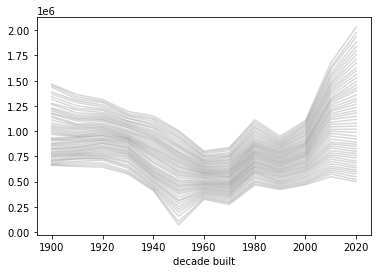

In [318]:
#The term prewar in Manhattan refers to buildings constructed before WW2. They allegedly have sturdier construction,
#more unique layouts, and a certain "charm" that commands a real estate premium.

#The proper way to compare the premium would be to quality control for things such as apartment size, building type,
#etc but for a quick approximation we can look at the dataset by lot (basically block level data) where we assume
#similar apartment types will be sold and split the apartment data into decade of build
apt_by_decade = quick_pivot("decade built","lot","sale price").tail(13)
apt_by_decade = apt_by_decade.fillna(method="ffill")

#for a quick visual we can take a look at the middle 50% of homes within each decade to look at both the dispersion
#within a decade and the trajectory over time. We plot each quantile of price from 25% to 75% over time.

for i in range (25,75,1):
    i = i / 100
    dfx = apt_by_decade.quantile(i,axis=1)
    dfx.plot(legend=None,alpha=0.3,color="grey")
    
#We see a dip post 1940 and then a gradual rise over time. One caveat is that because this data is in dollar terms, 
#the dispersion in the 2000s may just be a function of higher average price of homes sold

Glossary of terms found here:
https://www1.nyc.gov/assets/finance/downloads/pdf/07pdf/glossary_rsf071607.pdf

Building code descriptions found here:
https://www1.nyc.gov/assets/finance/jump/hlpbldgcode.html